<a href="https://colab.research.google.com/github/quillaur/data_learning/blob/main/data_science/machine_learning/reinforcement_learning/frozen_lake_q_table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q table basics

In [ ]:
!pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 22.3 MB/s 


In [ ]:
import numpy as np
import gym
import random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from google.colab.patches import cv2_imshow

# For rendering purpose
# https://stackoverflow.com/a/54047012
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

In [ ]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array", new_step_api=True, is_slippery=False)

In [ ]:
print(env.action_space.n)
print(env.observation_space.n)

4
16


In [ ]:
env.observation_space.shape

()

In [ ]:
env.action_space.shape

()

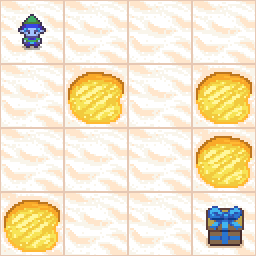

In [ ]:
# Play a step
env.reset()
cv2_imshow(env.render()[0])

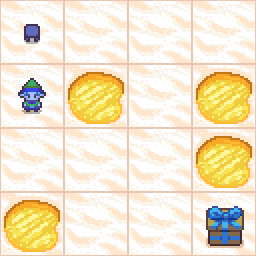

4

In [ ]:
action = env.action_space.sample()
ns = env.step(1)
cv2_imshow(env.render()[0])
ns[0]

In [ ]:
def play_game(env, render: bool=False, policy: object=lambda x: env.action_space.sample()):
  # Play a game
  state = env.reset()
  done = False
  turn_num = 0

  if render:
    cv2_imshow(env.render()[0])
    time.sleep(1)

  while not done and turn_num < 100:
    action = policy(state)
    state, reward, done, trunc, info = env.step(action)
    

    if render:
      clear_output(wait=True)
      cv2_imshow(env.render()[0])
      time.sleep(1)
    
    turn_num += 1

  return reward


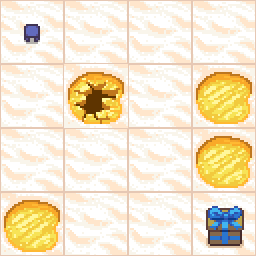

0.0

In [ ]:
play_game(env, True)

In [ ]:
class QAgent():
  def __init__(self, obs_space, action_space) -> None:
    self.learning_rate = 0.8           # Learning rate
    self.gamma = 0.9                 # Discounting rate

    # Exploration parameters
    self.epsilon = 1.0                 # Exploration rate
    self.max_epsilon = 1.0             # Exploration probability at start
    self.min_epsilon = 0.01            # Minimum exploration probability 
    self.decay_rate = 0.005             # Exponential decay rate for exploration probpass

    self.actions = action_space

    self.model = self.initialize(obs_space, action_space)
  
  def initialize(self, obs_space, action_space) -> None:
    return np.zeros((obs_space.n, action_space.n))
  
  def select_action(self, state) -> int:
    return np.argmax(self.model[state])
  
  def update_model(self, history) -> None:
    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    # qtable[new_state,:] : all the actions we can take from new state

    for state, action, reward, new_state, done in history:
      if not done and state != new_state:
        reward = reward + self.gamma * np.max(self.model[new_state])

      self.model[state, action] = (1 - self.learning_rate) * self.model[state, action] + self.learning_rate * reward
    
    # self.model[state, action] = self.model[state, action] + self.learning_rate * (reward + self.gamma * np.max(self.model[new_state, :]) - self.model[state, action])
  
  def update_epislon(self, step_num) -> None:
    # Reduce epsilon (because we need less and less exploration)
    self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay_rate*step_num) 

In [ ]:
def eval_agent(env, agent, num_episodes: int=10, with_progress: bool=False) -> float:
  rewards = 0
  if with_progress:
    for episode in trange(num_episodes):
        rewards += play_game(env, False, policy=agent.select_action)
  else:
    for episode in range(num_episodes):
      rewards += play_game(env, False, policy=agent.select_action)
    
  return rewards / num_episodes

In [ ]:
q_agent = QAgent(env.observation_space, env.action_space)

In [ ]:
q_agent.model

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
play_game(env, False, policy=q_agent.select_action)

0.0

In [ ]:
eval_agent(env, q_agent, 10, True)

  0%|          | 0/10 [00:00<?, ?it/s]

0.0

In [ ]:
def train_agent(env, agent, num_episodes: int=1000, with_eval: bool=True):
  # List of rewards
  performance = [eval_agent(env, agent)]

  # 2 For life or until learning is stopped
  for episode in trange(num_episodes):
      # Reset the environment
      history = []
      state = env.reset()
      done = False
      turn_num = 0
      while not done and turn_num < 100:
        exp_exp_tradeoff = random.uniform(0, 1)
    
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > agent.epsilon:
            action = agent.select_action(state)

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, trunc, info = env.step(action)

        # By specifying better the reward, I reduce the training time by more than 2X.
        if done:
          reward = reward + 9 if reward == 1 else reward - 10
        elif state == new_state:
          reward -= 1

        history.append([state, action, reward, new_state, done])
        
        # Our new state is state
        state = new_state
        
        turn_num += 1
      
      agent.update_model(history)
      agent.update_epislon(episode) 

      if with_eval and episode % 10 == 0:
        performance.append(eval_agent(env, agent))
  
  if with_eval:
    plt.plot(performance)
  
  return (agent, performance)


In [ ]:
q_agent = QAgent(env.observation_space, env.action_space)

  0%|          | 0/1000 [00:00<?, ?it/s]

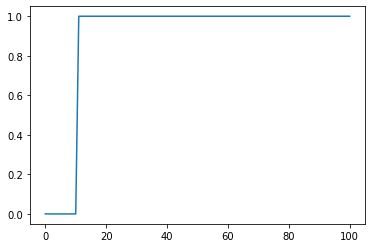

In [ ]:
q_agent, performance = train_agent(env, q_agent, 1000)

In [ ]:
q_agent.model

array([[ -1.        ,   5.9049    ,   5.9049    ,  -1.        ],
       [  5.31441   , -10.        ,   6.561     ,  -1.        ],
       [  4.68089753,   7.29      ,   4.82957422,  -0.99999998],
       [  6.34325133,  -9.984     ,  -0.99999744,  -0.992     ],
       [ -1.        ,   6.561     , -10.        ,   5.31441   ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -9.984     ,   8.1       ,  -9.999872  ,   6.45519938],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -1.        , -10.        ,   7.29      ,   5.9049    ],
       [  6.561     ,   8.1       ,   8.1       , -10.        ],
       [  7.28999627,   9.        ,  -9.99999898,   7.28959916],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [-10.        ,  -1.        ,   9.        ,   7.29      ],
       [  8.1       ,  -1.        ,  10.        ,   8.1       ],
       [  0.        ,   0

In [ ]:
eval_agent(env, q_agent, 100, True)

  0%|          | 0/100 [00:00<?, ?it/s]

1.0

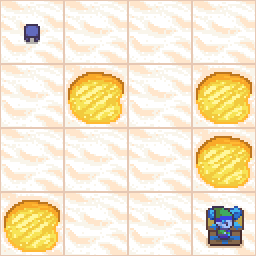

1.0

In [ ]:
play_game(env, True, policy=q_agent.select_action)